In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

### IMPORTS

In [ ]:
class MeanFieldVariationalDistribution(nn.Module):
    def __init__(self, nb_dim, mu=0.0, sigma=1.0, device='cpu'):
        super(MeanFieldVariationalDistribution, self).__init__()
        self.device = device
        self.nb_dim = nb_dim
        self.mu = nn.Parameter(torch.Tensor(nb_dim).to(self.device), requires_grad=True)
        self.rho = nn.Parameter(torch.Tensor(nb_dim).to(self.device), requires_grad=True)
        
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu)
            
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma)
        
        rho = torch.log(torch.exp(sigma) - 1)
        
        nn.init.constant_(self.mu, mu)
        nn.init.constant_(self.rho, rho)
        
    def set_mu(self, mu):
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu).float()
        nn.init.constant_(self.mu, mu)
        
        
    def set_rho(self, rho):
        if not torch.is_tensor(rho):
            rho = torch.tensor(rho).float()
        nn.init.constant_(self.rho, rho)
       
    def set_sigma(self, sigma):
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma).float()
        rho = self._sigma_to_rho(sigma)
        self.set_rho(rho)
        
    @property
    def sigma(self):
        return self._rho_to_sigma(self.rho)
        
    def sample(self, n=1):
        sigma = self._rho_to_sigma(self.rho)
        epsilon = torch.randn(size=(n,self.nb_dim)).to(self.device)
        return epsilon.mul(sigma).add(self.mu)
    
    def _rho_to_sigma(self, rho):
        sigma = torch.log(1 + torch.exp(rho))
        return sigma

    def _sigma_to_rho(self, sigma):
        rho = torch.log(torch.exp(sigma) - 1)
        return rho
    
    def requires_grad_(self, b):
        self.mu.requires_grad_(b)
        self.rho.requires_grad_(b)
    
    def log_prob(self, z):
        S = torch.diag(self.sigma)
        return torch.distributions.multivariate_normal.MultivariateNormal(self.mu, scale_tril=S).log_prob(z).unsqueeze(-1)

In [39]:
class MeanFieldVariationalAE(nn.Module):
    def __init__(self, lat_dim, H,H_, weights_dim, extraLayer=False, activation=nn.Sigmoid(), mu=0.0, sigma=1.0, device='cpu'):
        super(MeanFieldVariationalAE, self).__init__()
        self.device = device
        self.lat_dim = lat_dim
        self.weights_dim = weights_dim
        self.mfvar = MeanFieldVariationalDistribution(lat_dim,mu,sigma)
        self.layerIn=nn.Linear(lat_dim, H)
        self.layerOut=nn.Linear(H_,weights_dim)
        if extraLayer: 
            self.layerMid=nn.Linear(H, H_)
            self.decoder=nn.Sequential(
                       self.layerIn,
                       activation,
                       self.layerMid,
                       nn.ReLU(),
                       self.layerMid,
                       nn.ReLU(),
                       self.layerOut
                       )
        else:
            self.decoder=nn.Sequential(
               self.layerIn,
               activation,
               self.layerOut
               )
           
    def forward(self, n=1):
        sigma = self.mfvar.sigma
        epsilon = torch.randn(size=(n,self.lat_dim)).to(self.device)
        lat=epsilon.mul(sigma).add(self.mfvar.mu)
        return self.decoder(lat)

In [20]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [45]:
torch.set_default_dtype(torch.float64)

# Model principal

In [42]:
mixture = [torch.distributions.normal.Normal(5.0, 0.5),
           torch.distributions.normal.Normal(-5.0, 1.5),
           torch.distributions.normal.Normal(2.0, 1.0)]
proportions = torch.tensor([0.05, 0.35, 0.6])

In [43]:
def logposterior(x):
    v = [None]*len(mixture)
    for j in range(len(mixture)):
        v[j] = mixture[j].log_prob(x) + proportions[j].log()
    return torch.logsumexp(torch.stack(v), dim=0)

<IPython.core.display.Javascript object>


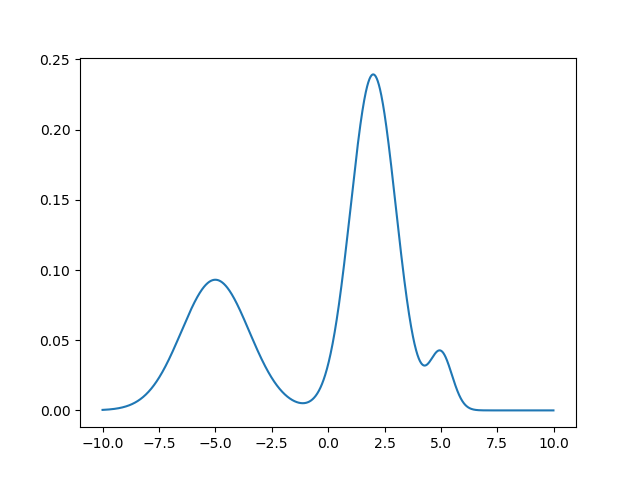

In [44]:
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), logposterior(x_lin).exp().detach().cpu().numpy())
plt.show()

# Modèle génératif: Hypernet autoencodeur

In [91]:
#choisir la dimension pour les paramètres latents
# lat_dim=5 donne des résultats intéressants!
lat_dim=20
nb_mid=10

In [92]:
# initialise 
# – (encodeur) une gaussienne diagonale N(0,sigma*I): mfvar ("dummy" prior sur les variables latentes)
# – (decodeur) un NN avec 1 layer param_count neurones, activtion nn.Tanh()/nn.ReLU(): decoder
# forward(n): échantilloner theta=mfvar.decoder(mfvar.sample(n))
sigma_p=1.
VAE = MeanFieldVariationalAE(lat_dim,nb_mid,nb_mid,1,extraLayer=False,activation=nn.ReLU(),sigma=sigma_p)
print('nb de paramètres VAE:'+str(get_param(VAE).shape[0]))
VAE


nb de paramètres VAE:261


MeanFieldVariationalAE(
  (mfvar): MeanFieldVariationalDistribution()
  (layerIn): Linear(in_features=20, out_features=10, bias=True)
  (layerOut): Linear(in_features=10, out_features=1, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [116]:
def init_weightsIn(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0., std=1.0)
        torch.nn.init.normal_(m.bias,mean=0., std=1.0)
        
def init_weightsOut(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0., std=1.0)
        torch.nn.init.normal_(m.bias,mean=0., std=1.0)
        #m.bias.data.fill_(0.)
        
VAE.layerIn.apply(init_weightsIn)
VAE.layerOut.apply(init_weightsOut)

Linear(in_features=10, out_features=1, bias=True)

# Training #

In [117]:
def log_norm_mv(theta1,theta2,H):
    mvn = torch.distributions.multivariate_normal.MultivariateNormal(theta1,H*torch.eye(param_count))
    return mvn.log_prob(theta2)


In [134]:
VAE_optimizer = torch.optim.Adam(VAE.parameters(), lr=.5)
VAE_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(VAE_optimizer, patience=60, factor=0.5)

In [135]:
%matplotlib inline
liveloss = PlotLosses()

In [136]:

H=.5 #Kernel Density Estimation hyper-parameter 
n_samples_VAR = 200
n_samples_ED=10

In [125]:
import seaborn as sns, numpy as np

In [131]:
X = VAE(1000)

<IPython.core.display.Javascript object>


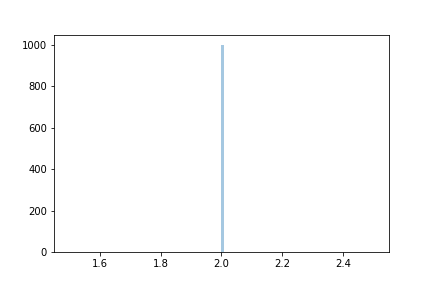

In [133]:
%matplotlib notebook
%matplotlib notebook
ax = sns.distplot(X.detach().numpy(), bins=100, kde=False)

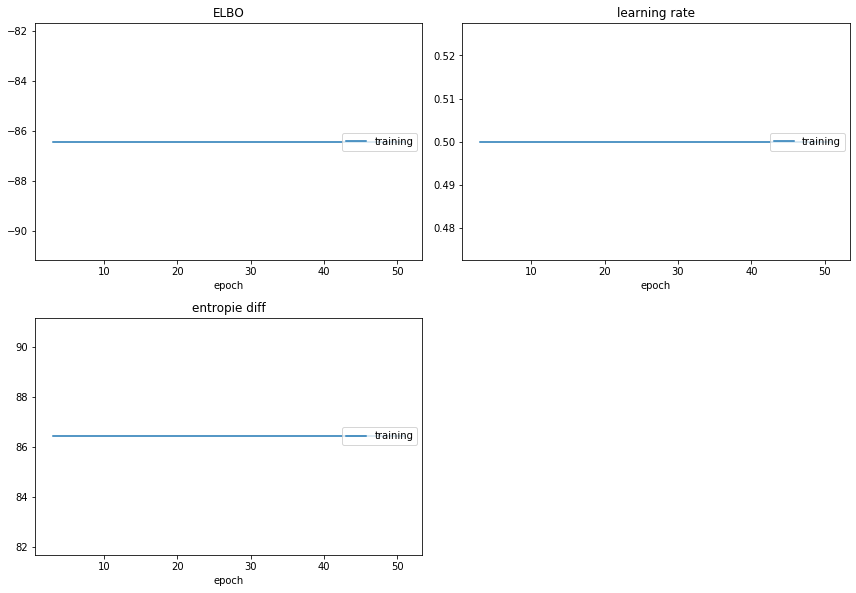

ELBO:
training   (min:  -86.427, max:  -86.427, cur:  -86.427)

learning rate:
training   (min:    0.500, max:    0.500, cur:    0.500)

entropie diff:
training   (min:   86.427, max:   86.427, cur:   86.427)


KeyboardInterrupt: 

In [137]:
%matplotlib inline
for t in range(10000):
    logs = {}
    VAE_optimizer.zero_grad()

    learning_rate = VAE_optimizer.param_groups[0]['lr']
    

    LP=torch.Tensor(n_samples_VAR)
    for i in range(n_samples_VAR):
        theta=VAE()
        LP[i]=logposterior(theta)
    
    LQ=torch.Tensor(n_samples_ED,n_samples_ED)
    theta_ED=VAE(n_samples_ED)
    for i in range(n_samples_ED):
        for j in range(i+1):
            LQ[i,j]=LQ[j,i]=log_norm_mv(theta_ED[i],theta_ED[j],H)      
    ED=LQ.logsumexp(0)-torch.log(torch.Tensor([n_samples_ED]))    
    
    L = ED.mean() #- LP.mean()

    L.backward()

    VAE_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    logs['entropie diff'] = -ED.mean().detach().clone().cpu().numpy()
#    logs['predictive likelihood'] = LL.mean().detach().clone().cpu().numpy()
    liveloss.update(logs)

        
    if t % 5 == 0:
        liveloss.draw()

    VAE_optimizer.step()

    if learning_rate < 0.00001:
        break

# Résultats #

In [ ]:
(-ED.mean(),LP.mean())

<IPython.core.display.Javascript object>


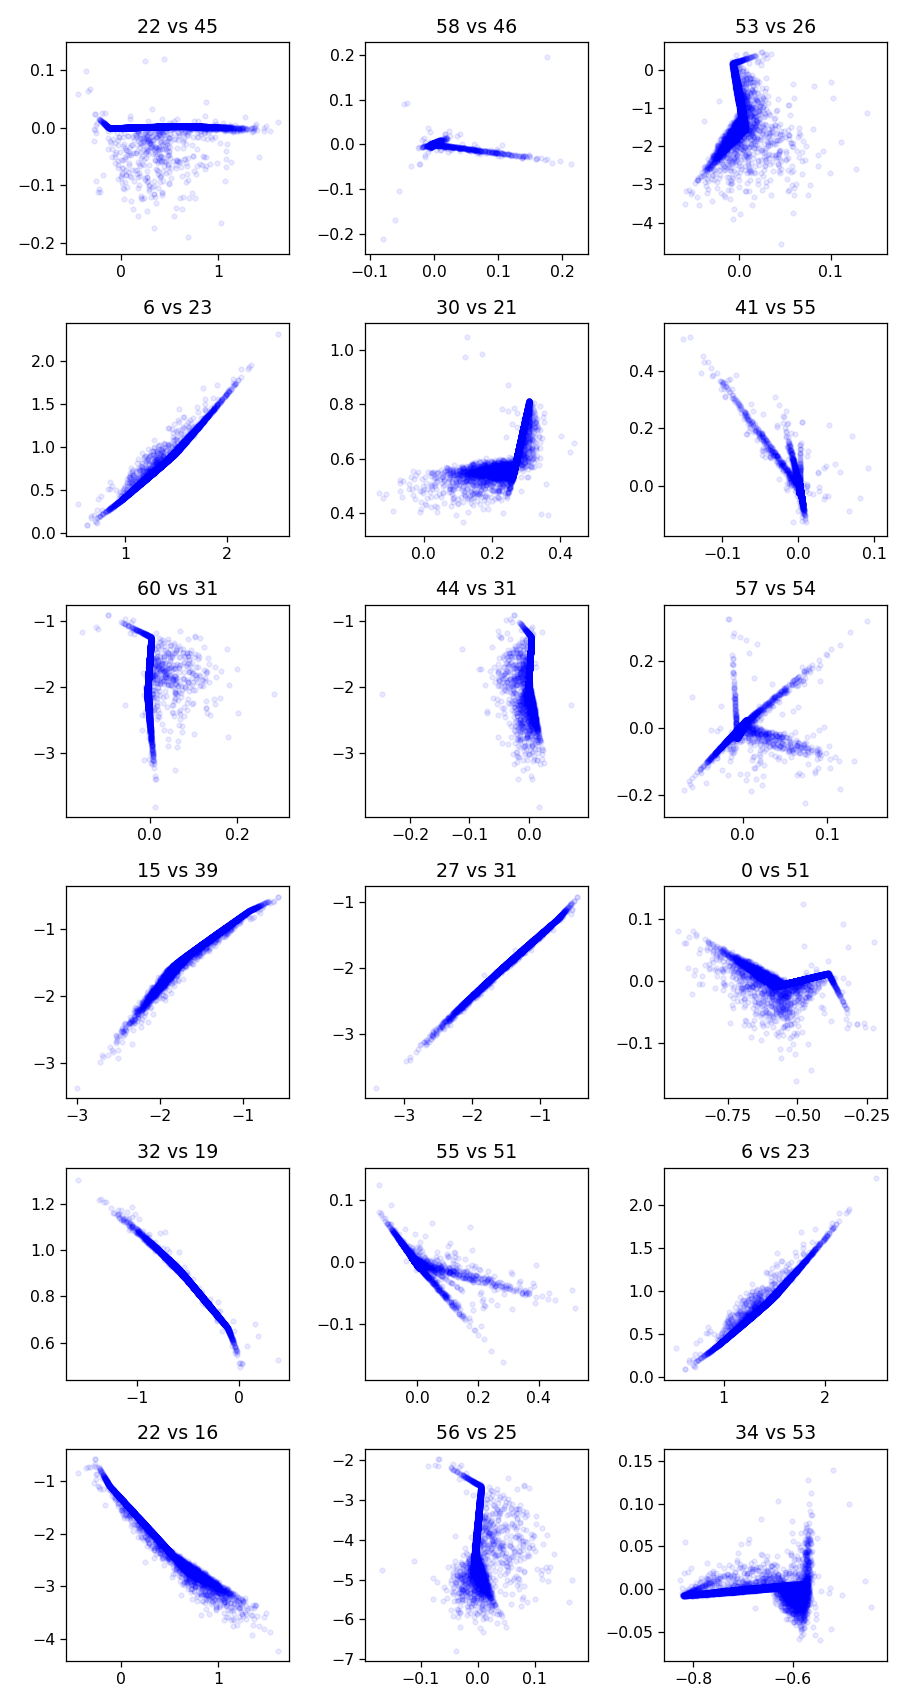

In [30]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

# aperçu de la distibution apprise sur les paramètres du modèle primaire.
# sampling of VAE 10 000 times and plotting a few 2D projections of the sampled parameters


L = VAE(10000).detach().numpy()


fig, axs = plt.subplots(6, 3,figsize=(8,15))
for k in range(6):
    for l in range(3):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].scatter(L[:,i[0]],L[:,i[1]],marker='.',alpha=0.08,color='blue')
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()

## Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution ##


<IPython.core.display.Javascript object>


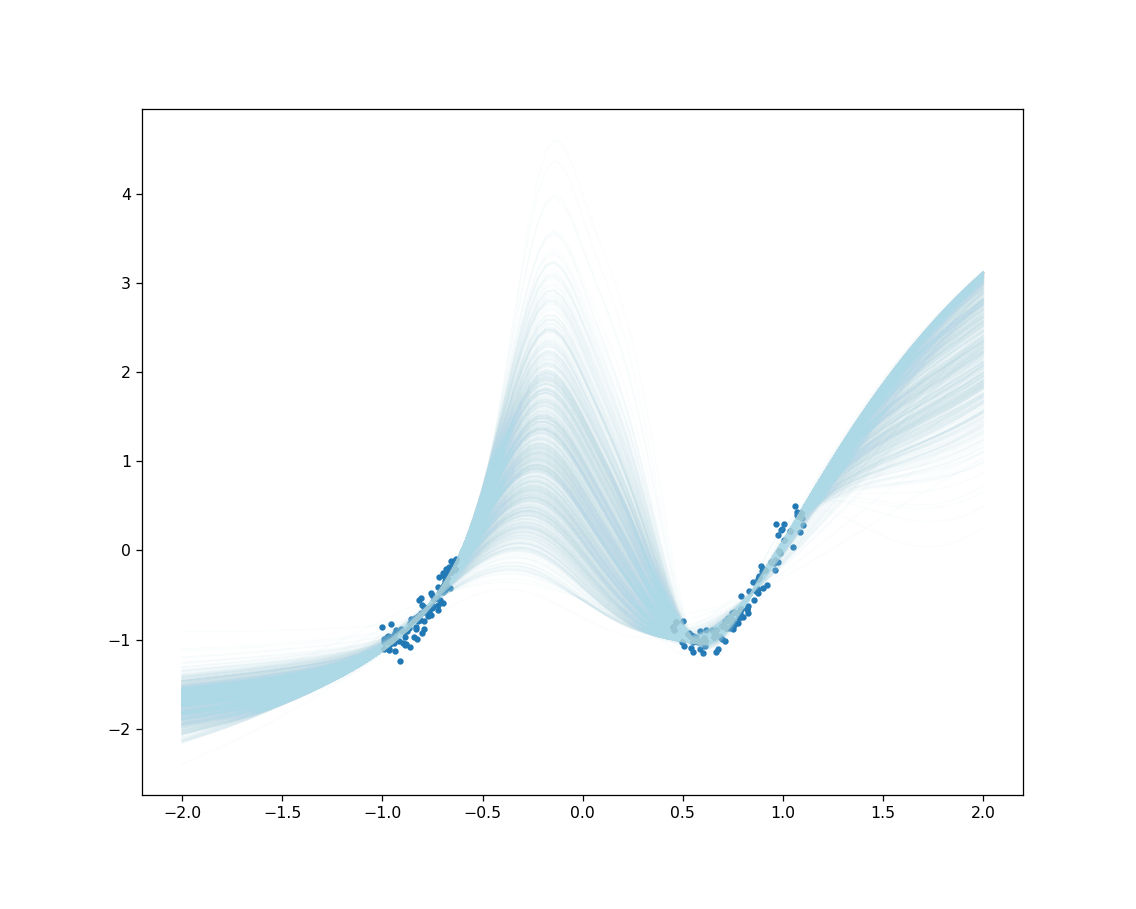

In [31]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook


x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
plt.scatter(x_data.cpu(), y_data.cpu(),marker='.')
for i in range(1000):
    theta=VAE()
    set_all_parameters(model, theta)
    y_test = model(x_test)    
#    plt.axis('scaled')
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')



In [105]:
# aperçu de la distibution apprise sur les paramètres du modèle primaire.
# sampling of VAE 10 000 times and plotting a few 2D projections of the sampled parameters
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt


L = VAE(10000).detach()
P=torch.Tensor(10000,1)

for i in range(10000):
    P[i]=logposterior(L[i].unsqueeze(0))

print((P.mean(),P.std()))


(tensor(37.2269), tensor(92.1520))


<IPython.core.display.Javascript object>


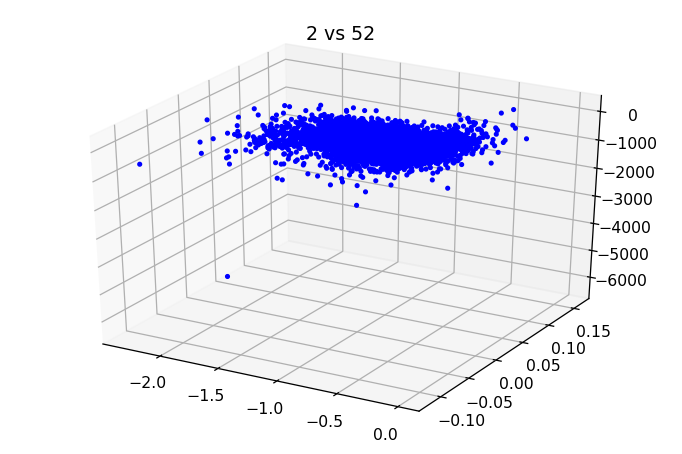

In [113]:
%matplotlib notebook

fig = plt.figure()

for k in range(1):
    for l in range(1):
        k_=k+1
        l_=l+1
        ax = fig.add_subplot(k_,1,l_, projection='3d')
        i=(2,52)#np.random.choice(a=np.arange(param_count), size=2,replace=False)
        ax.scatter(L[:,i[0]],L[:,i[1]],P, marker='.',alpha=1.,color='blue')
        ax.set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()